In [ ]:
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip3 install torchinfo

In [1]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import torchvision.models as models
from torchinfo import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
import torchvision.transforms as tt
from torchvision.datasets.folder import default_loader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
%matplotlib inline

**GPU**

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

"""Move tensor(s) to chosen device"""
def to_device(data, device):
  if isinstance(data, (list,tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """Wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
  """Yield a batch of data after moving it to device"""
    for b in self.dl: 
      yield to_device(b, self.device)

  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [ ]:
device = get_default_device()
device

**Dataset Lookthrough**

In [ ]:
data_dir = 'archive/temp_dir'
dataset = ImageFolder(data_dir)
len(dataset)

17817

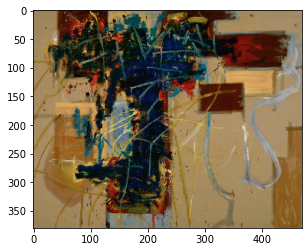

In [ ]:
img, label = dataset[0]
plt.imshow(img)

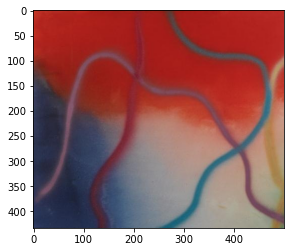

In [ ]:
img, label = dataset[750]
plt.imshow(img)

**Data preprocessing**
- resize to 64 x 64
- convert them to tensors and normalize them
- create dataloader
- look at sample

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(data_dir, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # [128, 3, 64, 64]

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

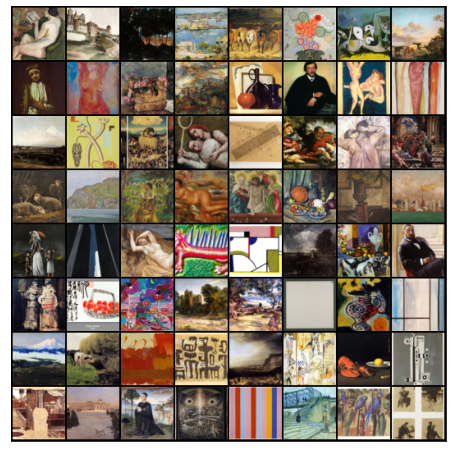

In [ ]:
# random samples from dataset
show_batch(train_dl)

In [ ]:
# move data to GPU
train_dl = DeviceDataLoader(train_dl, device)

**Discriminator Network**
- use a convolutional neural networks (CNN) which outputs a single number output for every image
- use stride of 2 to progressively reduce the size of the output feature map

In [ ]:
sample_discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
summary(sample_discriminator, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 64, 32, 32]         3,072
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─LeakyReLU: 1-3                         [128, 64, 32, 32]         --
├─Conv2d: 1-4                            [128, 128, 16, 16]        131,072
├─BatchNorm2d: 1-5                       [128, 128, 16, 16]        256
├─LeakyReLU: 1-6                         [128, 128, 16, 16]        --
├─Conv2d: 1-7                            [128, 256, 8, 8]          524,288
├─BatchNorm2d: 1-8                       [128, 256, 8, 8]          512
├─LeakyReLU: 1-9                         [128, 256, 8, 8]          --
├─Conv2d: 1-10                           [128, 512, 4, 4]          2,097,152
├─BatchNorm2d: 1-11                      [128, 512, 4, 4]          1,024
├─LeakyReLU: 1-12                        [128, 512, 4, 4]  

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Dropout(0.2),
    nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Dropout(0.2),
    nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
    # nn.BatchNorm2d(256),
    # nn.LeakyReLU(0.2, inplace=True),

    # out: 256 x 8 x 8

    nn.Dropout(0.2),
    nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
    # nn.BatchNorm2d(512),
    # nn.LeakyReLU(0.2, inplace=True),
    
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=3, stride=2, padding=0, bias=False),
    nn.BatchNorm2d(1),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
summary(discriminator, input_size=(batch_size, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─LeakyReLU: 1-2                         [128, 64, 32, 32]         --
├─Dropout: 1-3                           [128, 64, 32, 32]         --
├─Conv2d: 1-4                            [128, 128, 16, 16]        73,728
├─BatchNorm2d: 1-5                       [128, 128, 16, 16]        256
├─LeakyReLU: 1-6                         [128, 128, 16, 16]        --
├─Dropout: 1-7                           [128, 128, 16, 16]        --
├─Conv2d: 1-8                            [128, 256, 8, 8]          294,912
├─BatchNorm2d: 1-9                       [128, 256, 8, 8]          512
├─LeakyReLU: 1-10                        [128, 256, 8, 8]          --
├─Dropout: 1-11                          [128, 256, 8, 8]          --
├─Conv2d: 1-12                           [128, 512, 4, 4]          1,17

**Generator Network**
- input: a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image
- convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28 using the ConvTranspose2d layer from PyTorch, which is performs to as a transposed convolution (also referred to as a deconvolution)

In [ ]:
latent_size = 128

In [ ]:
sample_generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
summary(sample_generator, input_size=(batch_size, latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─ConvTranspose2d: 1-1                   [128, 512, 4, 4]          1,048,576
├─BatchNorm2d: 1-2                       [128, 512, 4, 4]          1,024
├─ReLU: 1-3                              [128, 512, 4, 4]          --
├─ConvTranspose2d: 1-4                   [128, 256, 8, 8]          2,097,152
├─BatchNorm2d: 1-5                       [128, 256, 8, 8]          512
├─ReLU: 1-6                              [128, 256, 8, 8]          --
├─ConvTranspose2d: 1-7                   [128, 128, 16, 16]        524,288
├─BatchNorm2d: 1-8                       [128, 128, 16, 16]        256
├─ReLU: 1-9                              [128, 128, 16, 16]        --
├─ConvTranspose2d: 1-10                  [128, 64, 32, 32]         131,072
├─BatchNorm2d: 1-11                      [128, 64, 32, 32]         128
├─ReLU: 1-12                             [128, 64, 32, 

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [ ]:
summary(generator, input_size=(batch_size, latent_size, 1, 1))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─ConvTranspose2d: 1-1                   [128, 512, 4, 4]          1,048,576
├─BatchNorm2d: 1-2                       [128, 512, 4, 4]          1,024
├─LeakyReLU: 1-3                         [128, 512, 4, 4]          --
├─ConvTranspose2d: 1-4                   [128, 256, 8, 8]          2,097,152
├─BatchNorm2d: 1-5                       [128, 256, 8, 8]          512
├─LeakyReLU: 1-6                         [128, 256, 8, 8]          --
├─ConvTranspose2d: 1-7                   [128, 128, 16, 16]        524,288
├─BatchNorm2d: 1-8                       [128, 128, 16, 16]        256
├─LeakyReLU: 1-9                         [128, 128, 16, 16]        --
├─ConvTranspose2d: 1-10                  [128, 64, 32, 32]         131,072
├─BatchNorm2d: 1-11                      [128, 64, 32, 32]         128
├─LeakyReLU: 1-12                        [128, 64, 32, 

torch.Size([128, 3, 64, 64])


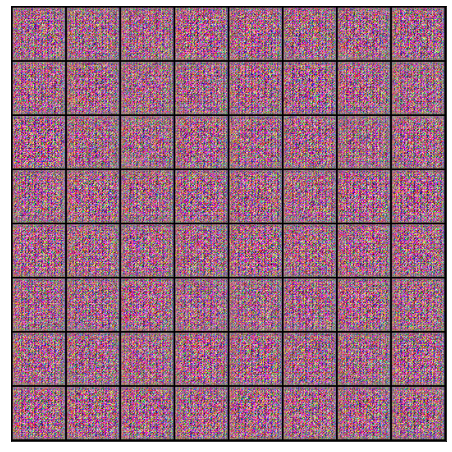

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

**Discriminator Training**
- use the binary cross entropy loss function
- input 1 as real and 0 as fake image from generator
- first pass a batch of real images, and compute the loss, setting the target labels to 1
- then pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0
- add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator

In [ ]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()
    
  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1)
  fake_images = generator(latent)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

**Generator Training**
- generate a batch of images using the generator, pass it into the discriminator
- calculate the loss by setting the target labels to 1
- use the loss to perform gradient descent

In [ ]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()
    
  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1)
  fake_images = generator(latent)
    
  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1)
  loss = F.binary_cross_entropy(preds, targets)
  
  # Update generator weights
  loss.backward()
  opt_g.step()
    
  return loss.item()

**Generated Images**

In [ ]:
date = '0319'
img_dir = date + '_plot'

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(img_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


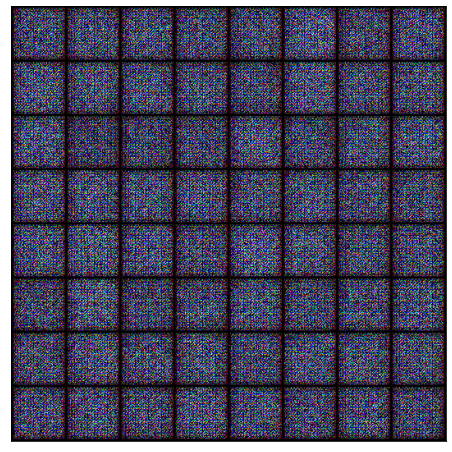

In [ ]:
save_samples(0, fixed_latent)

**Training the full loop**

In [ ]:
lr = 0.0002
epochs = 300

In [ ]:
def fit(epochs, lr, start_idx=1):
  torch.cuda.empty_cache()

  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []
    
  # optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # real_images = [128, 3, 64, 64]
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      loss_g = train_generator(opt_g)
            
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
        
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
          epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    save_samples(epoch+start_idx, fixed_latent, show=False)
    
  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1/300], loss_g: 5.2201, loss_d: 0.4484, real_score: 0.9128, fake_score: 0.2712
Saving generated-images-0001.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2/300], loss_g: 9.7153, loss_d: 0.1475, real_score: 0.8944, fake_score: 0.0001
Saving generated-images-0002.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3/300], loss_g: 1.9997, loss_d: 0.4637, real_score: 0.7904, fake_score: 0.1718
Saving generated-images-0003.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4/300], loss_g: 2.6564, loss_d: 0.5815, real_score: 0.6361, fake_score: 0.0657
Saving generated-images-0004.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5/300], loss_g: 1.3577, loss_d: 1.2996, real_score: 0.4214, fake_score: 0.1102
Saving generated-images-0005.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6/300], loss_g: 2.2438, loss_d: 1.2267, real_score: 0.3557, fake_score: 0.0209
Saving generated-images-0006.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7/300], loss_g: 5.6926, loss_d: 0.4680, real_score: 0.9477, fake_score: 0.3081
Saving generated-images-0007.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8/300], loss_g: 7.2376, loss_d: 0.6261, real_score: 0.9584, fake_score: 0.3819
Saving generated-images-0008.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9/300], loss_g: 3.3911, loss_d: 0.3845, real_score: 0.8937, fake_score: 0.2125
Saving generated-images-0009.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10/300], loss_g: 2.8853, loss_d: 1.1189, real_score: 0.4034, fake_score: 0.0214
Saving generated-images-0010.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [11/300], loss_g: 4.2427, loss_d: 0.5988, real_score: 0.8232, fake_score: 0.2996
Saving generated-images-0011.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [12/300], loss_g: 6.8189, loss_d: 0.1027, real_score: 0.9213, fake_score: 0.0154
Saving generated-images-0012.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [13/300], loss_g: 3.2058, loss_d: 0.2451, real_score: 0.9151, fake_score: 0.1292
Saving generated-images-0013.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [14/300], loss_g: 2.0082, loss_d: 0.5816, real_score: 0.6442, fake_score: 0.0973
Saving generated-images-0014.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [15/300], loss_g: 1.8383, loss_d: 0.6129, real_score: 0.6621, fake_score: 0.1139
Saving generated-images-0015.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [16/300], loss_g: 4.5336, loss_d: 0.3866, real_score: 0.9054, fake_score: 0.2230
Saving generated-images-0016.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [17/300], loss_g: 0.7947, loss_d: 0.6861, real_score: 0.5938, fake_score: 0.0892
Saving generated-images-0017.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [18/300], loss_g: 5.2185, loss_d: 0.2239, real_score: 0.8778, fake_score: 0.0761
Saving generated-images-0018.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [19/300], loss_g: 4.5996, loss_d: 0.2144, real_score: 0.9211, fake_score: 0.1173
Saving generated-images-0019.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [20/300], loss_g: 2.3336, loss_d: 0.3259, real_score: 0.9372, fake_score: 0.2022
Saving generated-images-0020.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [21/300], loss_g: 4.9631, loss_d: 0.2918, real_score: 0.9612, fake_score: 0.1962
Saving generated-images-0021.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [22/300], loss_g: 3.5806, loss_d: 0.1732, real_score: 0.9245, fake_score: 0.0834
Saving generated-images-0022.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [23/300], loss_g: 3.5742, loss_d: 0.7454, real_score: 0.9282, fake_score: 0.4543
Saving generated-images-0023.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [24/300], loss_g: 0.3757, loss_d: 1.5886, real_score: 0.2595, fake_score: 0.0058
Saving generated-images-0024.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [25/300], loss_g: 3.5567, loss_d: 0.4531, real_score: 0.6958, fake_score: 0.0365
Saving generated-images-0025.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [26/300], loss_g: 3.6361, loss_d: 0.3233, real_score: 0.7706, fake_score: 0.0391
Saving generated-images-0026.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [27/300], loss_g: 2.4176, loss_d: 0.3365, real_score: 0.9405, fake_score: 0.2153
Saving generated-images-0027.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [28/300], loss_g: 3.7566, loss_d: 0.2688, real_score: 0.8724, fake_score: 0.1100
Saving generated-images-0028.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [29/300], loss_g: 0.2233, loss_d: 1.1264, real_score: 0.4280, fake_score: 0.0360
Saving generated-images-0029.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [30/300], loss_g: 2.9838, loss_d: 0.3907, real_score: 0.9500, fake_score: 0.2526
Saving generated-images-0030.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [31/300], loss_g: 1.9911, loss_d: 0.4758, real_score: 0.7102, fake_score: 0.0681
Saving generated-images-0031.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [32/300], loss_g: 1.3204, loss_d: 0.7762, real_score: 0.5094, fake_score: 0.0340
Saving generated-images-0032.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [33/300], loss_g: 1.8967, loss_d: 0.2521, real_score: 0.8669, fake_score: 0.0849
Saving generated-images-0033.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [34/300], loss_g: 2.6165, loss_d: 0.1814, real_score: 0.9615, fake_score: 0.1212
Saving generated-images-0034.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [35/300], loss_g: 4.9115, loss_d: 0.0668, real_score: 0.9868, fake_score: 0.0503
Saving generated-images-0035.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [36/300], loss_g: 0.9595, loss_d: 0.5363, real_score: 0.6833, fake_score: 0.0800
Saving generated-images-0036.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [37/300], loss_g: 1.5380, loss_d: 0.4757, real_score: 0.7046, fake_score: 0.0567
Saving generated-images-0037.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [38/300], loss_g: 7.6248, loss_d: 0.7351, real_score: 0.9486, fake_score: 0.4537
Saving generated-images-0038.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [39/300], loss_g: 6.0469, loss_d: 1.0996, real_score: 0.9927, fake_score: 0.5634
Saving generated-images-0039.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [40/300], loss_g: 5.6443, loss_d: 0.2869, real_score: 0.7850, fake_score: 0.0160
Saving generated-images-0040.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [41/300], loss_g: 3.8869, loss_d: 0.2156, real_score: 0.8701, fake_score: 0.0627
Saving generated-images-0041.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [42/300], loss_g: 6.9790, loss_d: 0.9832, real_score: 0.9227, fake_score: 0.4951
Saving generated-images-0042.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [43/300], loss_g: 2.9469, loss_d: 0.3163, real_score: 0.7883, fake_score: 0.0587
Saving generated-images-0043.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [44/300], loss_g: 6.2024, loss_d: 0.4819, real_score: 0.8633, fake_score: 0.2509
Saving generated-images-0044.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [45/300], loss_g: 2.9537, loss_d: 0.0996, real_score: 0.9470, fake_score: 0.0421
Saving generated-images-0045.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [46/300], loss_g: 0.9038, loss_d: 0.4491, real_score: 0.6848, fake_score: 0.0375
Saving generated-images-0046.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [47/300], loss_g: 0.3118, loss_d: 1.4356, real_score: 0.3721, fake_score: 0.1642
Saving generated-images-0047.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [48/300], loss_g: 4.8191, loss_d: 0.2191, real_score: 0.8381, fake_score: 0.0313
Saving generated-images-0048.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [49/300], loss_g: 0.2835, loss_d: 1.1292, real_score: 0.3952, fake_score: 0.0164
Saving generated-images-0049.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [50/300], loss_g: 3.5823, loss_d: 0.7616, real_score: 0.8415, fake_score: 0.3714
Saving generated-images-0050.png


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [51/300], loss_g: 2.9252, loss_d: 0.3374, real_score: 0.7737, fake_score: 0.0421
Saving generated-images-0051.png


  0%|          | 0/140 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

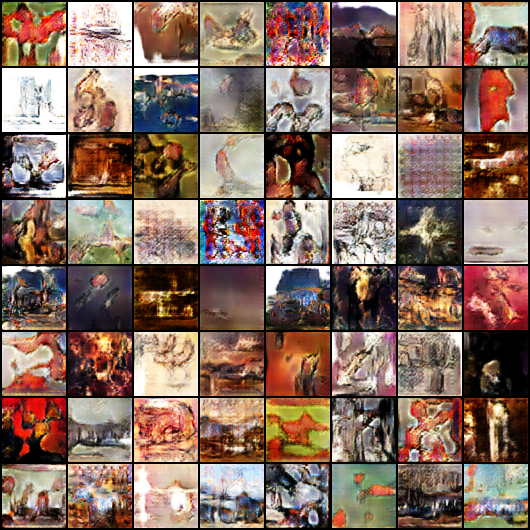

In [ ]:
Image('0318_generated_plots/generated-images-0050.png')

In [ ]:
loss_g, losses_d, real_scores, fake_scores = history